In [261]:
%run spot_functions.ipynb
%run gl_functions.ipynb

In [3]:
# sdk, robot, id_client, \
# robot_state_client, command_client, \
# image_client, graph_nav_client, \
# world_object_client, manipulation_api_client = initRobot('192.168.50.3')
# timeout_sec = 5

In [4]:
# lease_client, lease, lease_keep_alive = getLease(robot)

In [5]:
# Initialize Groundlight API

GROUNDLIGHT_API_TOKEN = 'api_2Au8NPiTMbSLQ73Vjr2eMhX2qUh_pt4EEKhtDNgnjN3dUAr89YANDcYsmBkJZV'
gl = Groundlight(api_token=GROUNDLIGHT_API_TOKEN)
detectors = gl.list_detectors()
depthDet = detectors.results[0]
noDepthDet = detectors.results[2]

In [6]:
depthDet

Detector(id='det_2B2ZfRGBvaToFVHuFSsETz76UUS', type=<DetectorTypeEnum.detector: 'detector'>, created_at=datetime.datetime(2022, 6, 24, 14, 30, 42, 854373, tzinfo=tzoffset(None, -25200)), name='depthRubiksCube', query="Is entire Rubik's cube contained within image?", group_name='__DEFAULT', confidence_threshold=0.8)

In [7]:
noDepthDet

Detector(id='det_2AuDZFz06xbytjWrTL0dUvsjOz7', type=<DetectorTypeEnum.detector: 'detector'>, created_at=datetime.datetime(2022, 6, 21, 15, 30, 29, 961429, tzinfo=tzoffset(None, -25200)), name='newRubiksCube', query="Is entire Rubik's cube contained within image?", group_name='__DEFAULT', confidence_threshold=0.5)

In [308]:
getBattInfo()

Battery at: 3.0 %. Robot has 190 seconds left


(3.0, 190)

In [244]:
success = powerOn(robot)

True


In [296]:
cmd = RobotCommandBuilder.arm_stow_command()
cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+5)

In [231]:
bdcrc.blocking_selfright(command_client, timeout_sec = timeout_sec)

In [74]:
bdcrc.blocking_sit(command_client, timeout_sec = timeout_sec)

In [11]:
bdcrc.blocking_stand(command_client, timeout_sec = timeout_sec)

In [297]:
cmd = RobotCommandBuilder.claw_gripper_open_fraction_command(0.0)
cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+timeout_sec)

In [294]:
moveTo, lookAt = randomGazeDown()

armOrigin = np.array([0.35,0,0.1])

print(np.round(moveTo,2), np.sum( (moveTo-armOrigin)**2 ) **0.5, np.round(lookAt, 2))

moveToAndLookAt(moveTo,lookAt, True)

time.sleep(0.5)

[0.9  0.26 0.43] 0.6921670295393736 [ 1.19  0.23 -0.62]


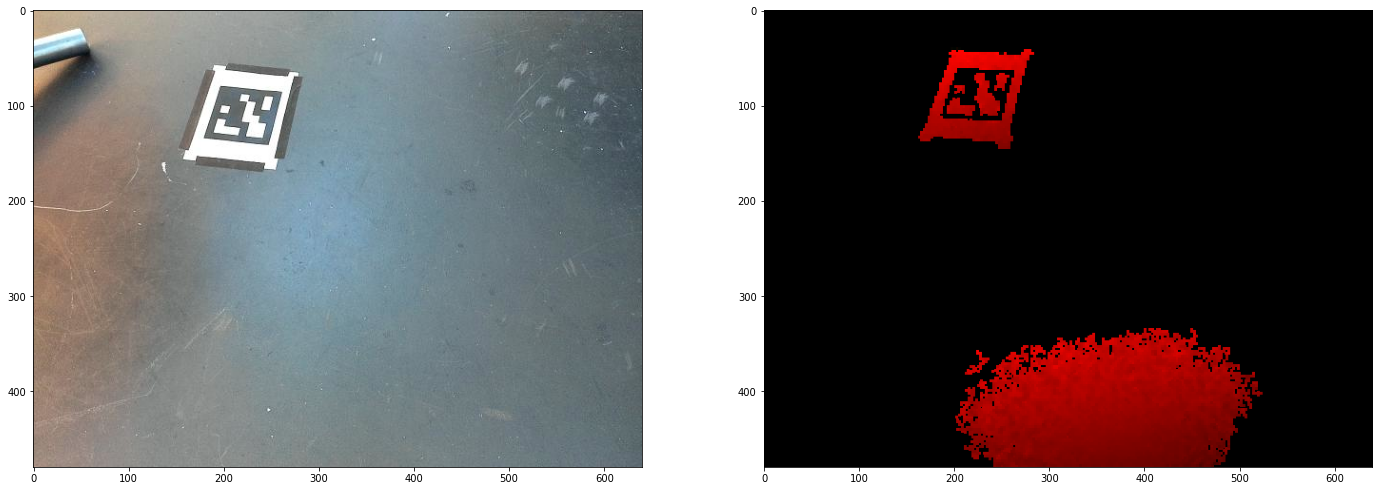

In [295]:
handColorImg, image_response = capHandImage(image_client, 'hand_color_image')
handDepthImg, _ = capHandImage(image_client, 'hand_depth_in_hand_color_frame')

imgZero = np.zeros((handDepthImg.shape[0], handDepthImg.shape[1],1))

handDepthImg = np.concatenate((handDepthImg, imgZero), 2).astype(np.uint8)

fig, ax = plt.subplots(1,2, figsize = (24,9))
ax[0].imshow(handColorImg)
ax[1].imshow(handDepthImg)

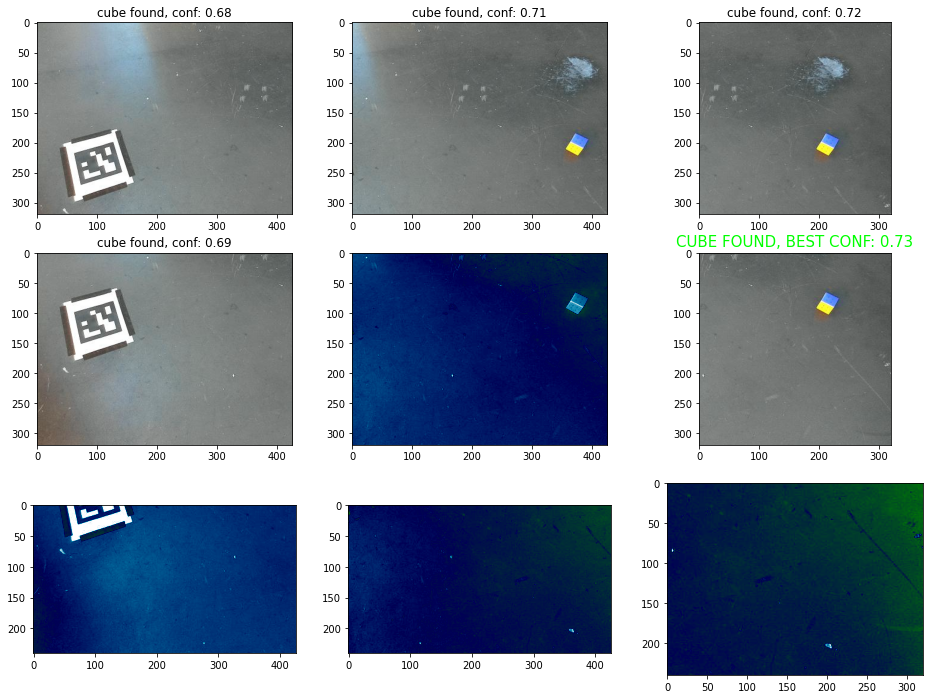

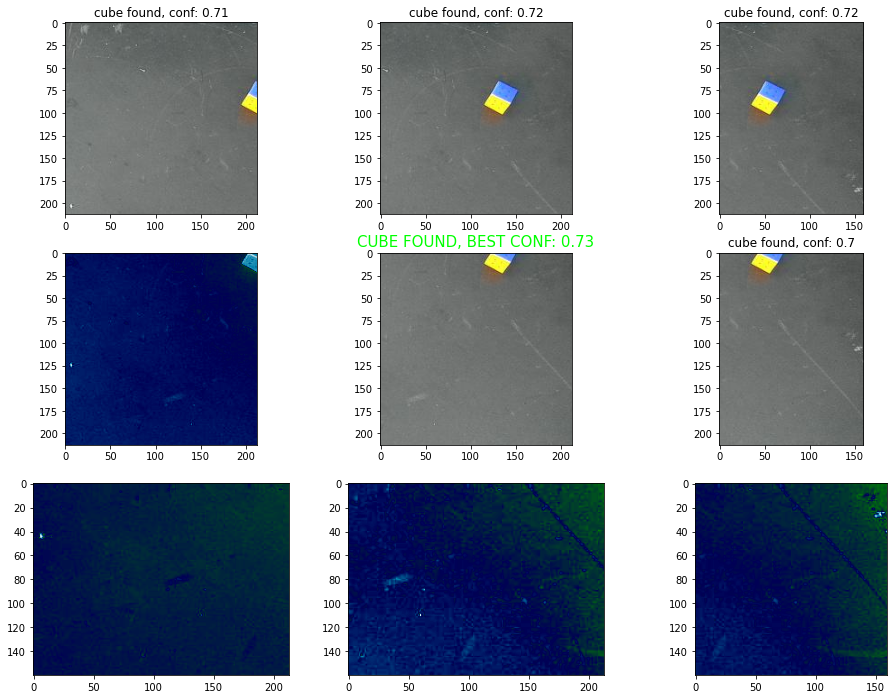

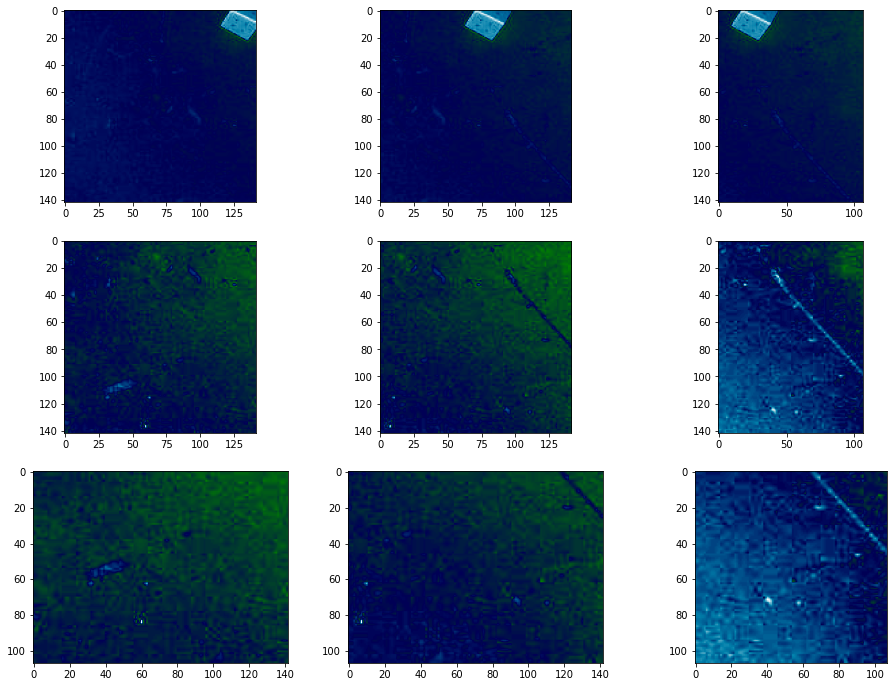

In [291]:
tree = sweepLocalizeColorDepth(det, handColorImg, handDepthImg, verbose = True)

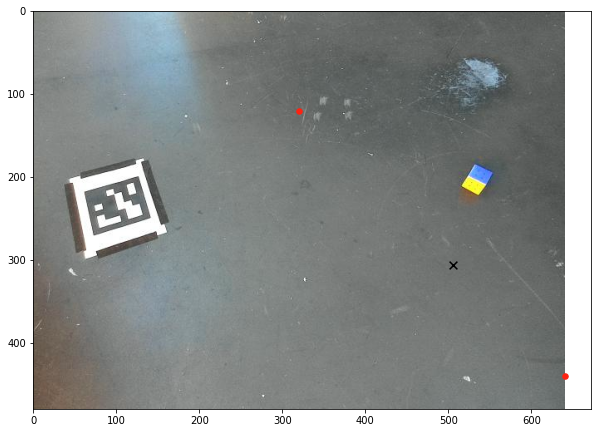

In [292]:
pxLoc = assemblePxTree(tree)
plotTreeOnImage(tree, handColorImg)
plt.show()

In [23]:
def depthVsNoDepth():
    moveTo, lookAt = randomGazeDown()

    #armOrigin = np.array([0.35,0,0.1])

    #print(np.round(moveTo,2), np.sum( (moveTo-armOrigin)**2 ) **0.5, np.round(lookAt, 2))

    moveToAndLookAt(moveTo,lookAt, True)

    cmd = RobotCommandBuilder.claw_gripper_open_fraction_command(1.0)
    cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+timeout_sec)

    time.sleep(0.5)


    handColorImg, image_response = capHandImage(image_client, 'hand_color_image')
    handDepthImg, _ = capHandImage(image_client, 'hand_depth_in_hand_color_frame')

    imgZero = np.zeros((handDepthImg.shape[0], handDepthImg.shape[1],1))

    handDepthImg = np.concatenate((handDepthImg, imgZero), 2).astype(np.uint8)



    print('localizing with no depth')
    start_time_sec = time.time()
    treeNoDepth = sweepLocalize(noDepthDet, handColorImg, verbose = False)
    end_time_sec = time.time()
    print('Localizing cube without depth took', end_time_sec - start_time_sec, 'seconds')

    print('localizing with depth')
    start_time_sec = time.time()
    treeWithDepth = sweepLocalizeColorDepth(depthDet, handColorImg, handDepthImg, verbose = False)
    end_time_sec = time.time()
    print('Localizing cube with depth took', end_time_sec - start_time_sec, 'seconds')

    return handColorImg, handDepthImg, treeNoDepth, treeWithDepth

In [24]:
def plotTreeComparison(handColorImg, handDepthImg, treeNoDepth, treeWithDepth):
    fig, ax = plt.subplots(2,2, figsize = (16,12))

    ax[0,0].imshow(handColorImg)
    ax[0,0].set_title('Original Image', fontsize = 15)
    ax[0,1].imshow(handDepthImg)
    ax[0,1].set_title('Depth Image', fontsize = 15)

    if treeNoDepth is not None:
        plotTreeOnImage(ax[1,0], treeNoDepth, handColorImg)
        ax[1,0].set_title('Localization of cube WITHOUT depth', fontsize = 15)
    if treeWithDepth is not None:
        plotTreeOnImage(ax[1,1], treeWithDepth, handColorImg)
        ax[1,1].set_title('Localization of cube WITH depth', fontsize = 15)
        
    plt.show()

localizing with no depth
Localizing cube without depth took 10.736263990402222 seconds
localizing with depth
Localizing cube with depth took 4.142128944396973 seconds


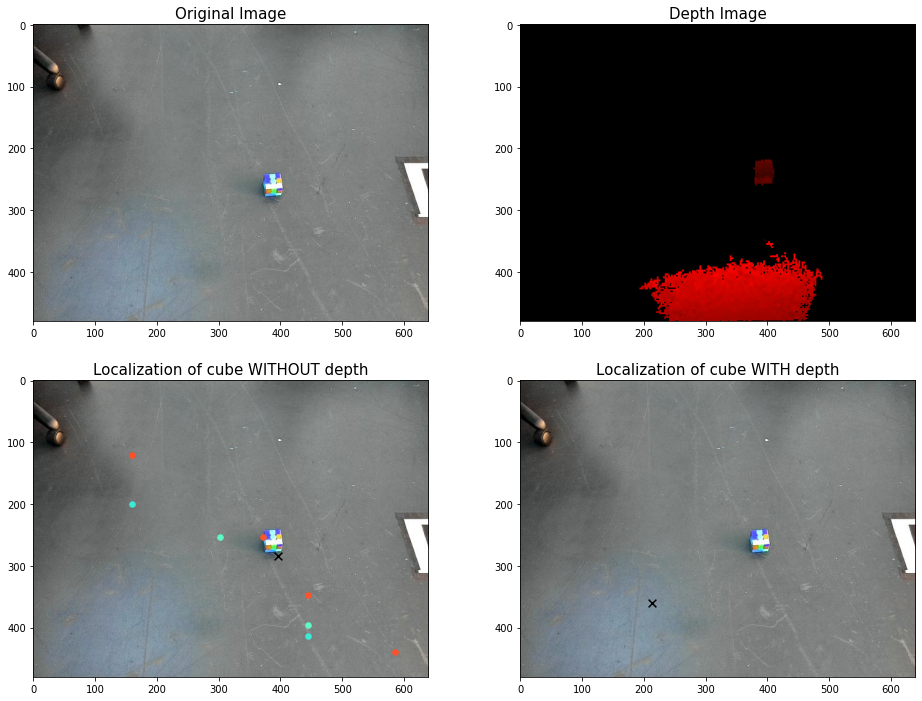

In [26]:
for i in range(1):
    handColorImg, handDepthImg, treeNoDepth, treeWithDepth = depthVsNoDepth()
    plotTreeComparison(handColorImg, handDepthImg, treeNoDepth, treeWithDepth)

localizing with no depth
Localizing cube without depth took 13.806353569030762 seconds
localizing with depth
Localizing cube with depth took 13.058660745620728 seconds


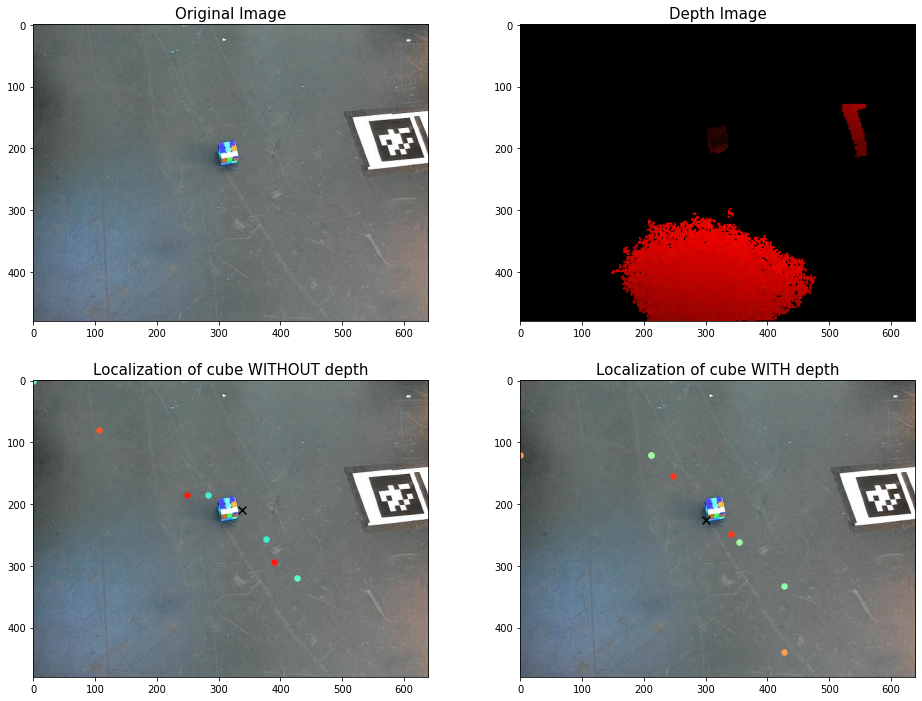

localizing with no depth
Localizing cube without depth took 11.652777194976807 seconds
localizing with depth
Localizing cube with depth took 12.761257648468018 seconds


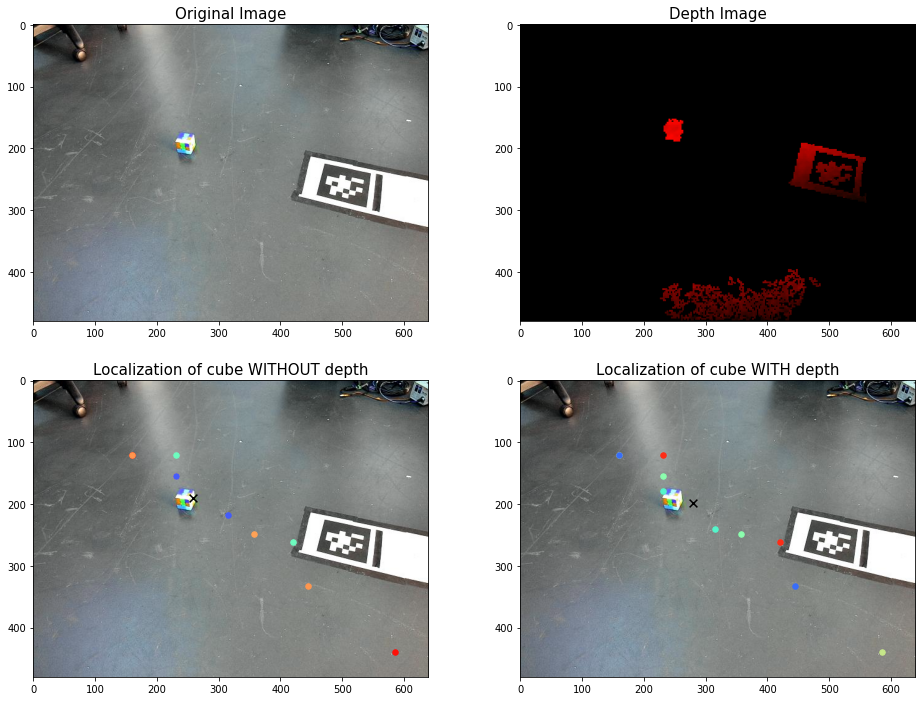

localizing with no depth
Localizing cube without depth took 8.859455585479736 seconds
localizing with depth
Localizing cube with depth took 13.049072742462158 seconds


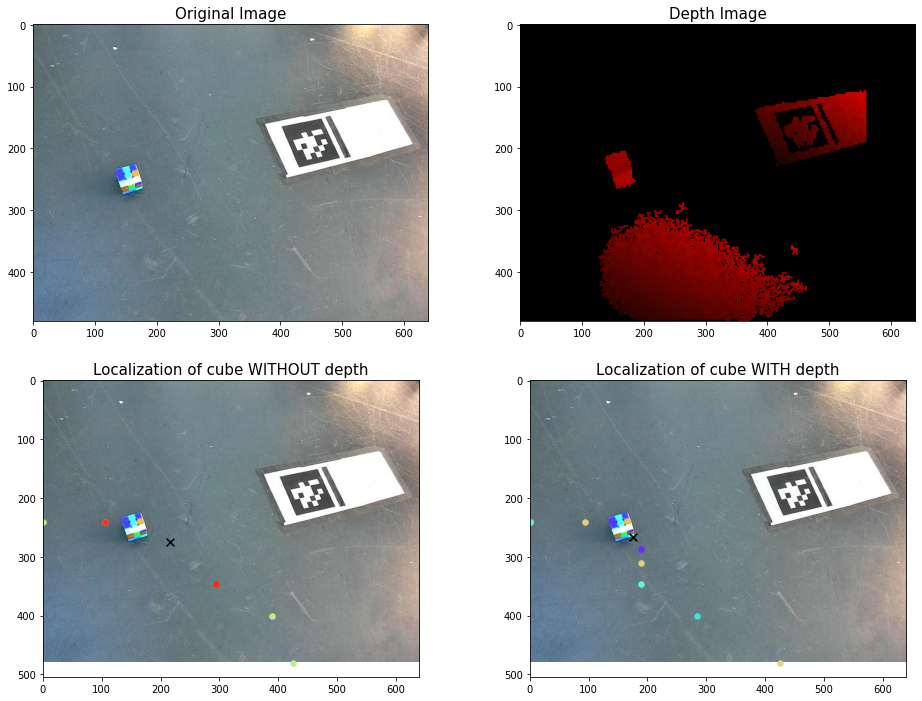

localizing with no depth
Localizing cube without depth took 9.970787525177002 seconds
localizing with depth
Localizing cube with depth took 12.906873226165771 seconds


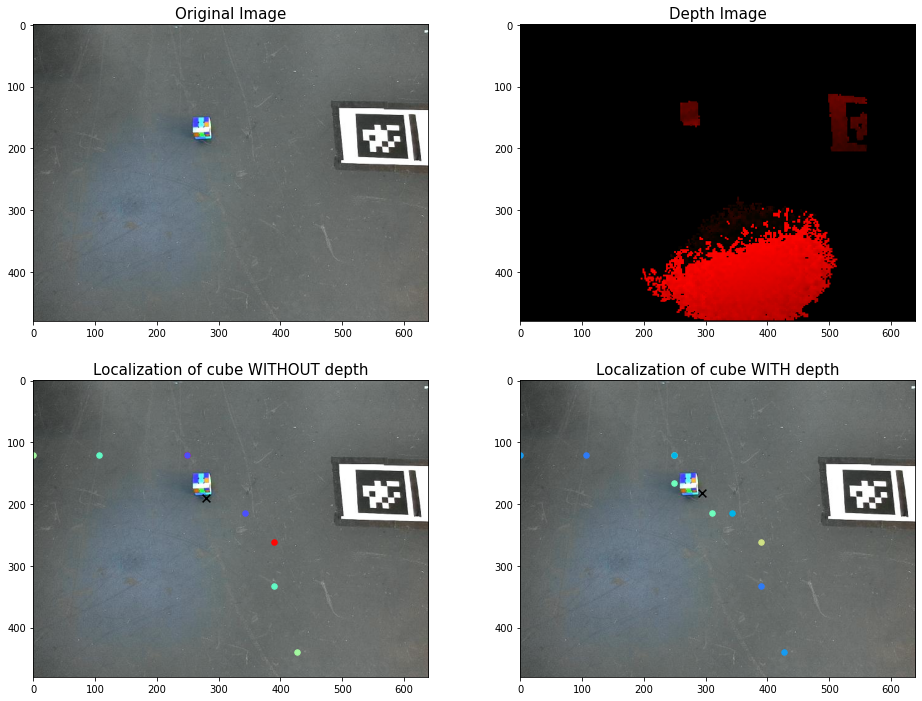

localizing with no depth
Localizing cube without depth took 10.116195440292358 seconds
localizing with depth
Localizing cube with depth took 11.671523332595825 seconds


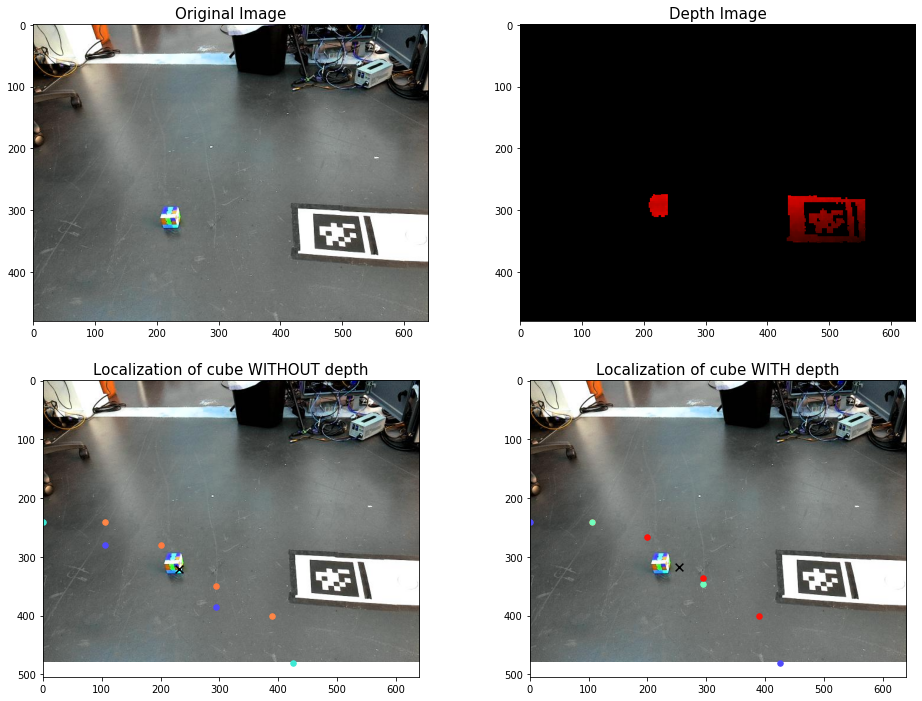

localizing with no depth
Localizing cube without depth took 6.650420188903809 seconds
localizing with depth
Localizing cube with depth took 5.878252029418945 seconds


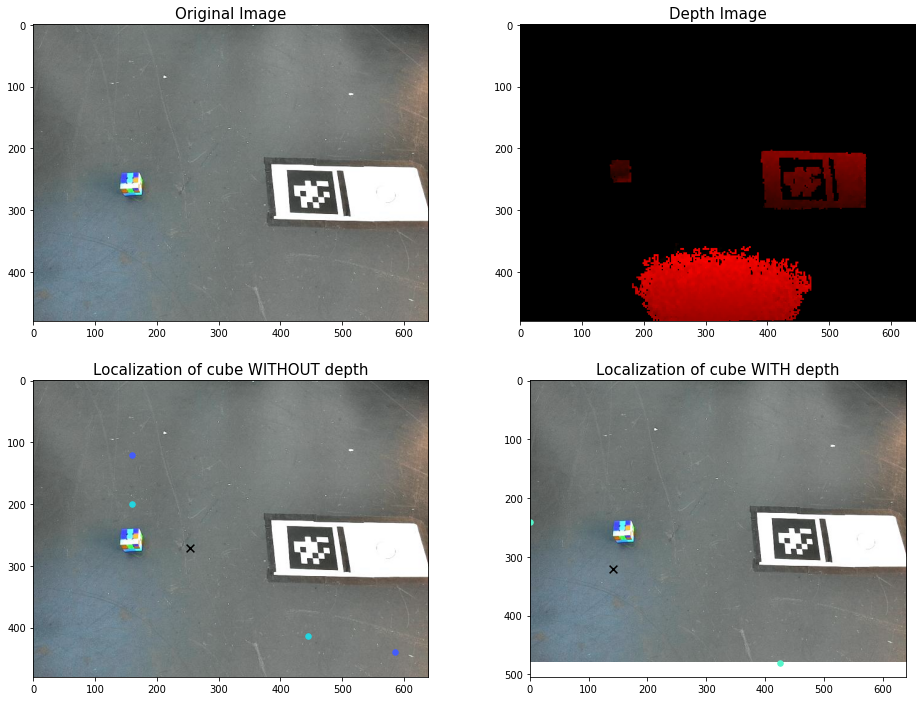

localizing with no depth
Localizing cube without depth took 10.687956094741821 seconds
localizing with depth
Localizing cube with depth took 13.625301122665405 seconds


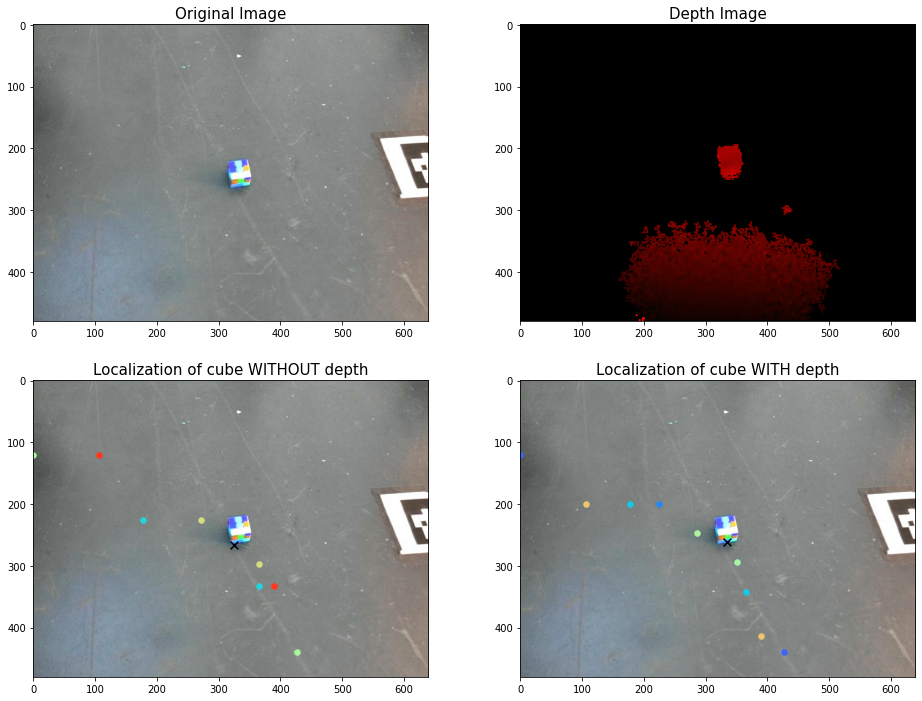

localizing with no depth
Localizing cube without depth took 7.328688621520996 seconds
localizing with depth
localizing with no depth
Localizing cube without depth took 8.275010585784912 seconds
localizing with depth
Localizing cube with depth took 9.229485511779785 seconds


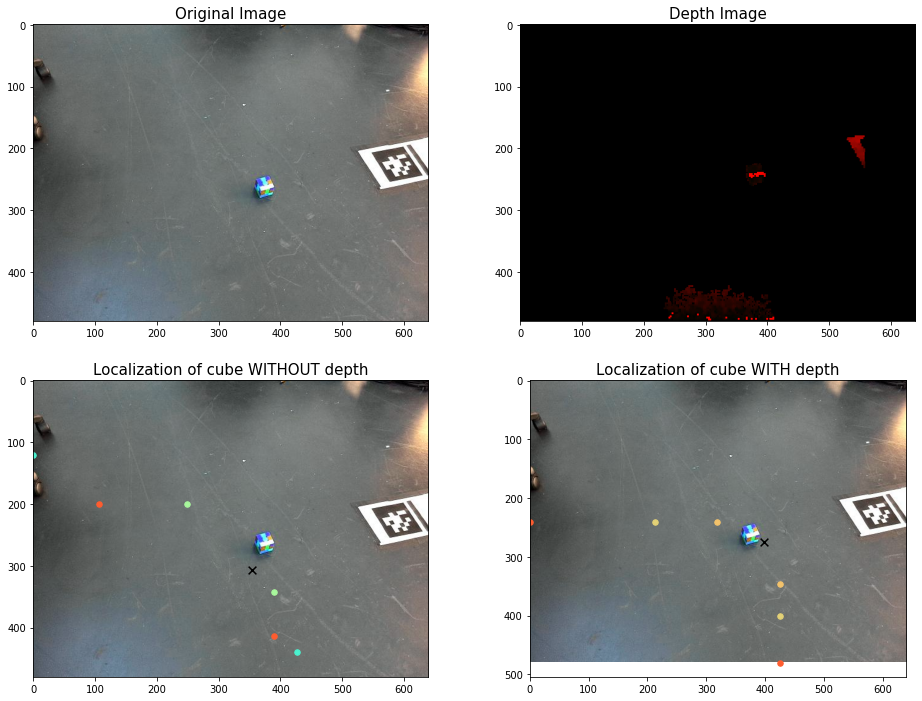

localizing with no depth
Localizing cube without depth took 10.297820091247559 seconds
localizing with depth
Localizing cube with depth took 9.217784881591797 seconds


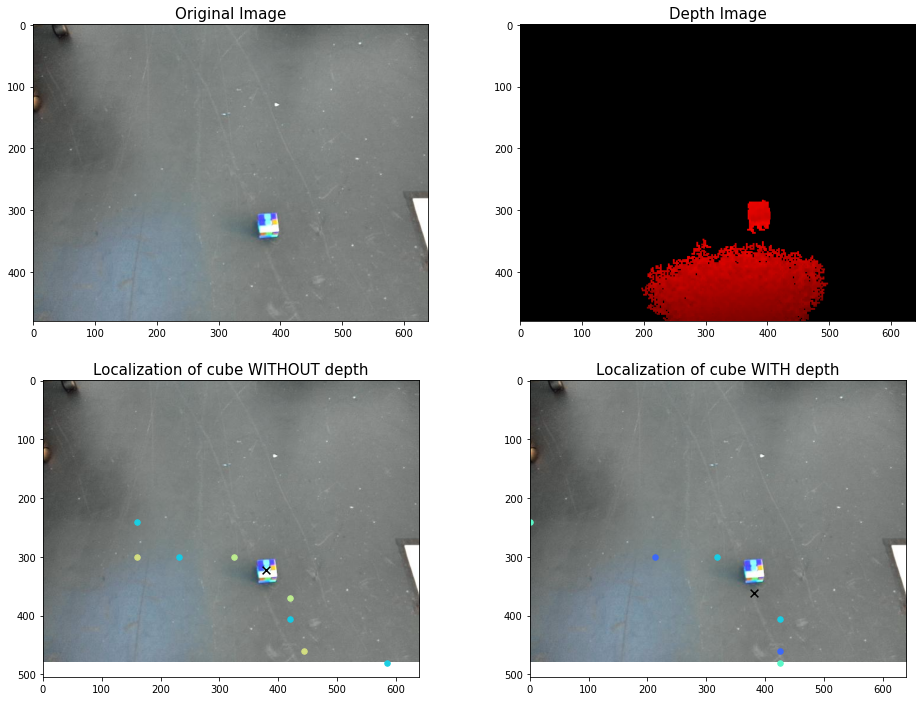

In [25]:
for i in range(10):
    handColorImg, handDepthImg, treeNoDepth, treeWithDepth = depthVsNoDepth()
    plotTreeComparison(handColorImg, handDepthImg, treeNoDepth, treeWithDepth)

In [15]:
def randomCubeDrop(command_client):
    randomLookDir = [((np.random.rand() * 2) - 1) * 2, 
                 (((np.random.rand()) * 2) - 1) * 3, 
                 np.random.rand() * (-2)  ]

    moveToAndLookAt([0.8,0,-0.35],randomLookDir, True)
    
    time.sleep(0.5)

    cmd = RobotCommandBuilder.claw_gripper_open_fraction_command(1.0)
    cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+timeout_sec)

    time.sleep(0.5)

    cmd = RobotCommandBuilder.arm_stow_command()
    cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+5)

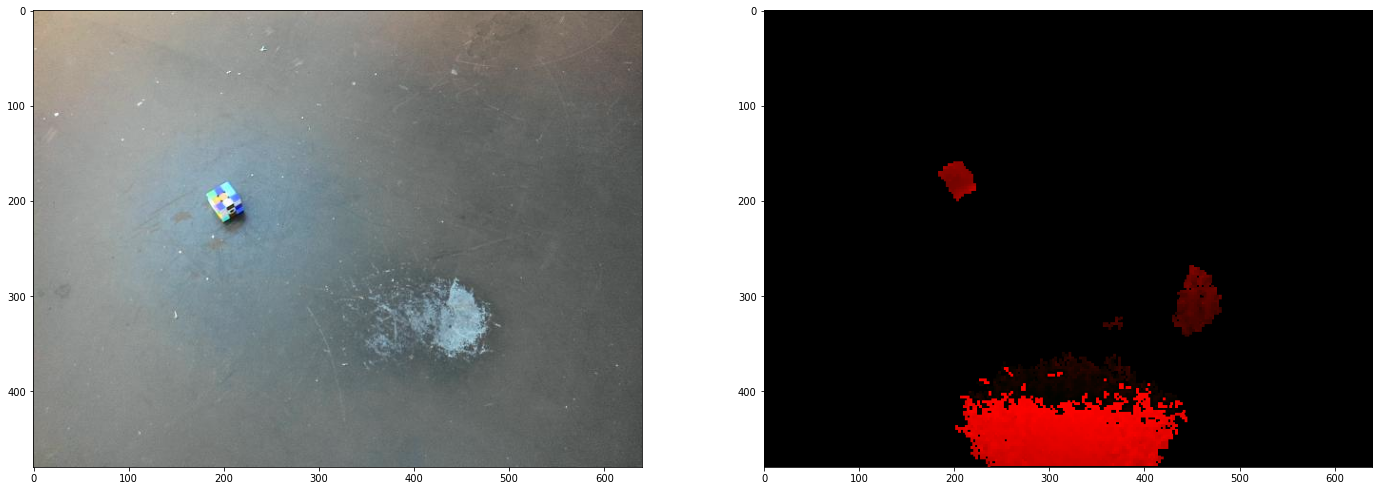

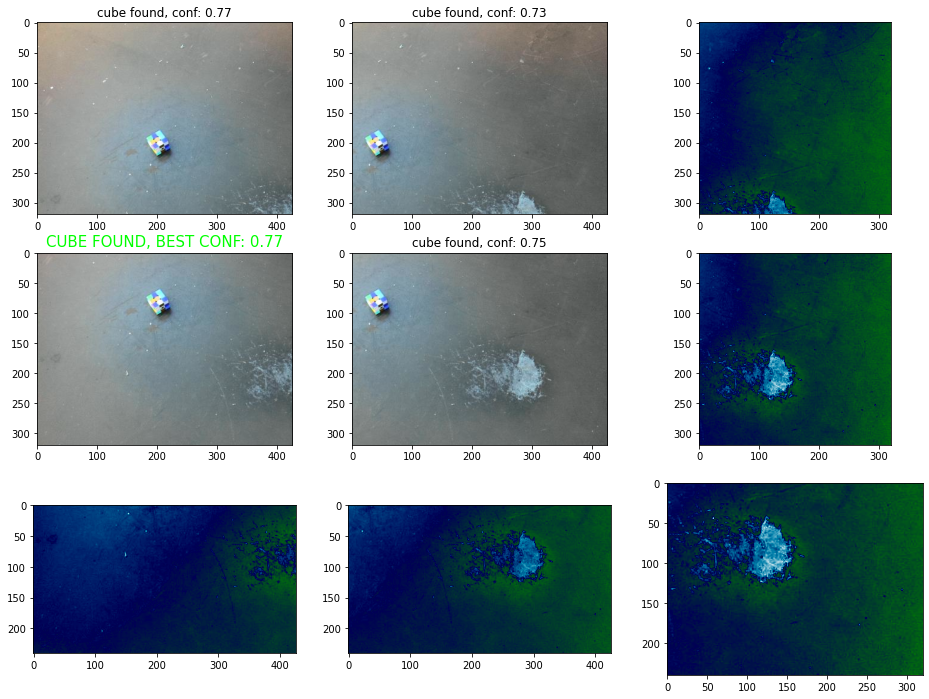

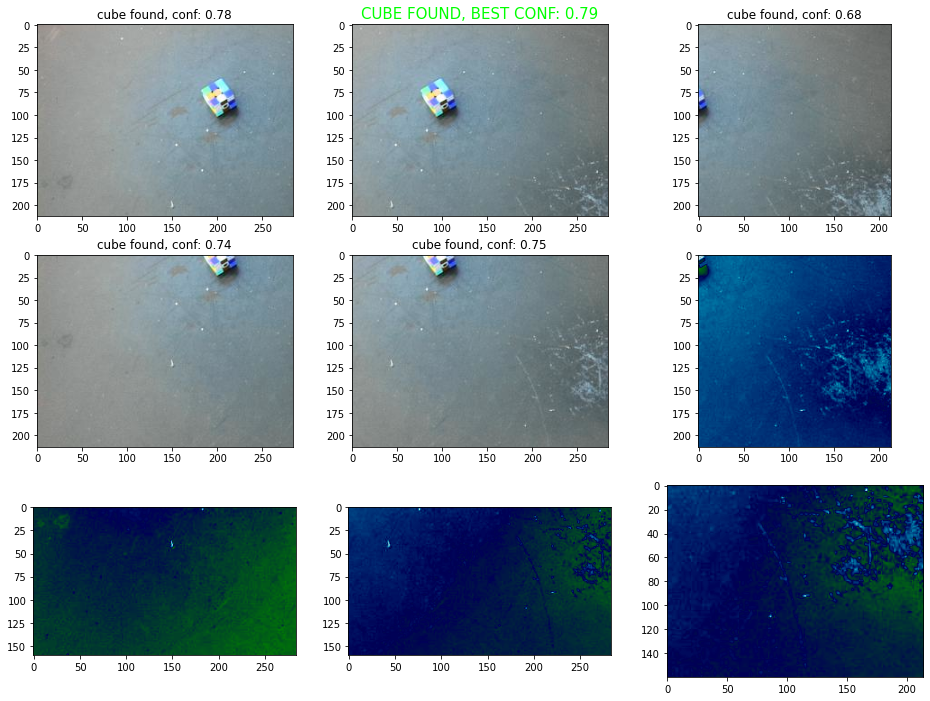

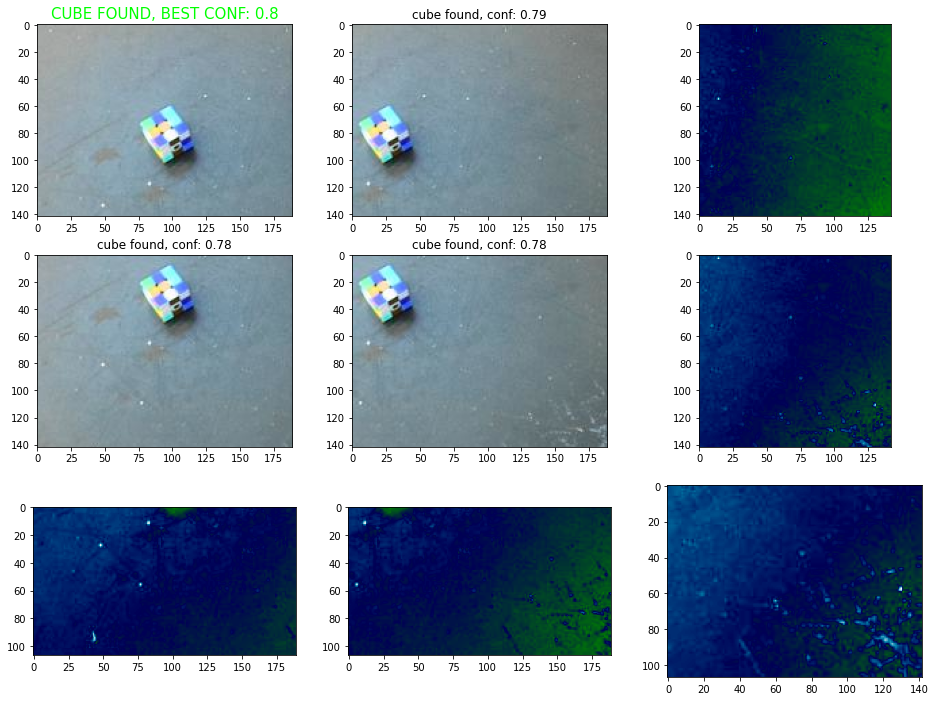

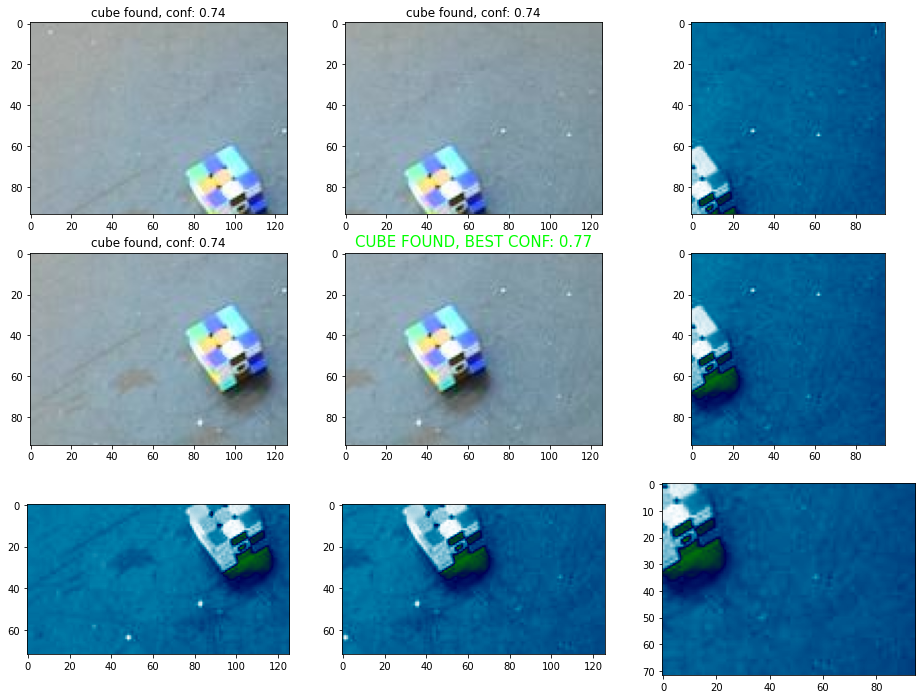

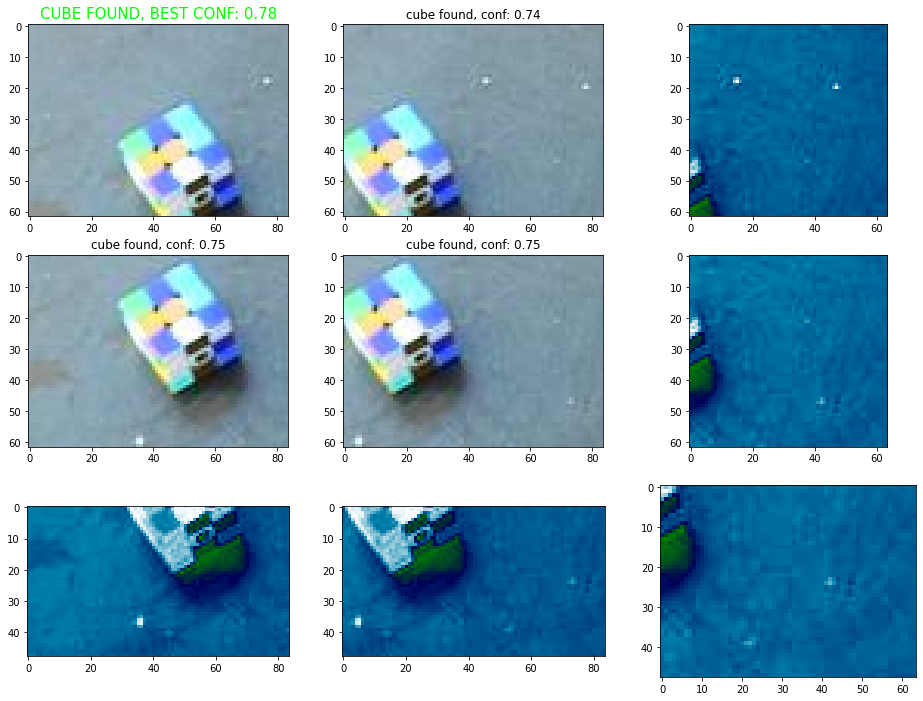

CUBE FOUND, PREPARING TO GRASP


TypeError: plotTreeOnImage() missing 1 required positional argument: 'img'

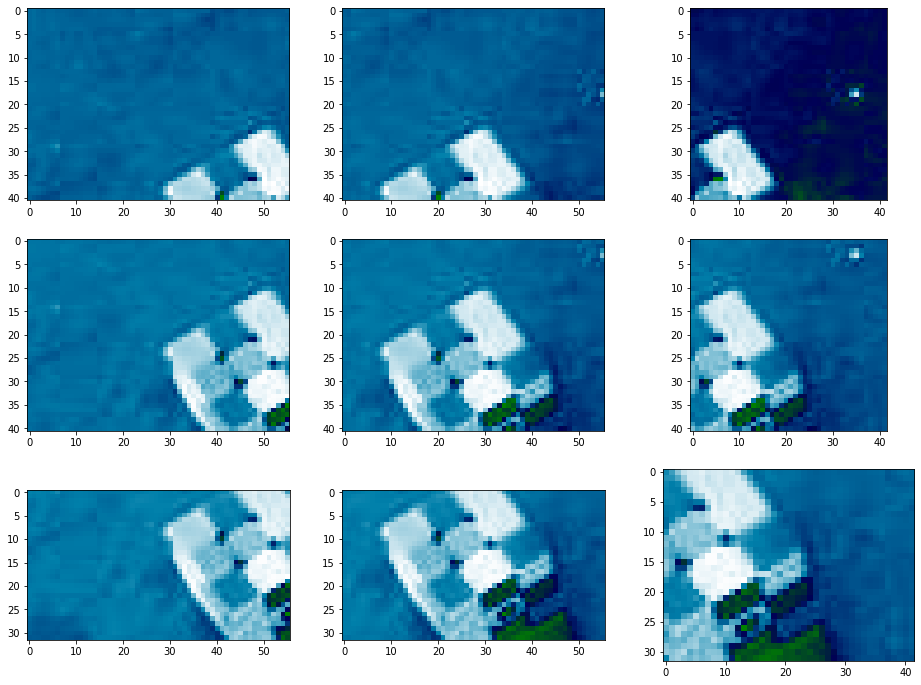

In [107]:
for i in range(6):
    bdcrc.blocking_stand(command_client, timeout_sec = timeout_sec)

    moveTo, lookAt = randomGazeDown()
    
    moveToAndLookAt(moveTo,lookAt, True)
    cmd = RobotCommandBuilder.claw_gripper_open_fraction_command(1.0)
    cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+timeout_sec)
    time.sleep(0.5)

    graph_response = graph_nav_client.clear_graph()

    handColorImg, image_response = capHandImage(image_client, 'hand_color_image')
    handDepthImg, _ = capHandImage(image_client, 'hand_depth_in_hand_color_frame')

    imgZero = np.zeros((handDepthImg.shape[0], handDepthImg.shape[1],1))

    handDepthImg = np.concatenate((handDepthImg, imgZero), 2).astype(np.uint8)

    fig, ax = plt.subplots(1,2, figsize = (24,9))
    ax[0].imshow(handColorImg)
    ax[1].imshow(handDepthImg)
    plt.show()
    
    time.sleep(0.1)
    
    cmd = RobotCommandBuilder.arm_stow_command()
    cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+5)
    bdcrc.block_until_arm_arrives(command_client, cmd_id, timeout_sec = time.time() + 3.0)
    
    time.sleep(1.5)

    tree = sweepLocalizeColorDepth(depthDet, handColorImg, handDepthImg, verbose = True)

    if tree is None:
        print('CUBE NOT FOUND')
        continue
    else:
        print('CUBE FOUND, PREPARING TO GRASP')

    plotTreeOnImage(tree, handColorImg)
    plt.show()

    pxLoc = assemblePxTree(tree)
    pick_vec = geometry_pb2.Vec2(x=pxLoc[0], y=pxLoc[1])

    grasp = manipulation_api_pb2.PickObjectInImage(
        pixel_xy=pick_vec, transforms_snapshot_for_camera=image_response.shot.transforms_snapshot,
        frame_name_image_sensor=image_response.shot.frame_name_image_sensor,
        camera_model=image_response.source.pinhole)

    grasp_request = manipulation_api_pb2.ManipulationApiRequest(pick_object_in_image=grasp)
    
    response, success = makeGrasp(grasp_request, graph_nav_client)
    if not success:
        print("SPOT FAILS TO MAKE GRASP", response.current_state)
        continue
        
    cmd = RobotCommandBuilder.arm_stow_command()
    cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+5)
    bdcrc.block_until_arm_arrives(command_client, cmd_id, timeout_sec = time.time() + 3.0)
    
    time.sleep(2)
    
    moveRobotRelative(command_client, -0.5, 0, 0)

    
    curState = robot_state_client.get_robot_state()
    wristPosRads = np.abs(curState.kinematic_state.joint_states[-1].position.value)
    
    if wristPosRads < np.pi/36:
        print('GRIPPER IS CLOSED. FAILED TO GRAB CUBE')
        continue
    
    randomCubeDrop(command_client)
    

In [26]:
response, success = makeGrasp(grasp_request, graph_nav_client)

In [28]:
randomCubeDrop(command_client)

In [285]:
upload_filepath = "/home/gluser/groundlight/bdspot/spot/loopGraph"
upload_graph_and_snapshots(graph_nav_client, upload_filepath)
success = graphLocalizeFiducial(command_client, graph_nav_client, robot_state_client)

Loading the graph from disk into local storage...
Loaded graph has 27 waypoints and 29 edges
Uploading the graph and snapshots to the robot...
attempt #:  0
SUCCESS: initialized location to using nearest fiducial


In [286]:
nav_to_cmd_id = graph_nav_client.navigate_to(waypointDict[9], timeout_sec)
waitUntilFinishedNav(nav_to_cmd_id)

In [287]:
wp_loc_proto = graphDelGetGraphLoc(graph_nav_client)

In [301]:
moveRobotRelative(command_client, -1, 0, 0)

In [302]:
response = upload_graph_and_snapshots(graph_nav_client, upload_filepath)

Loading the graph from disk into local storage...
Loaded graph has 27 waypoints and 29 edges
Uploading the graph and snapshots to the robot...


Upload complete! The robot is currently not localized to the map; please localize


In [303]:
graphLocalizeGuess(graph_nav_client, init_guess_loc = wp_loc_proto)

waypoint_id: "mono-eagle-pUcEzJeZxsXlz.HlH7T7yA=="
waypoint_tform_body {
  position {
    x: 3.337762110253042
    y: 5.3724189954044705
    z: -0.03405779900418985
  }
  rotation {
    x: 0.0007812665969696752
    y: -0.006964157489074912
    z: -0.7161556719377521
    w: 0.6979053490070506
  }
}

In [307]:
nav_to_cmd_id = graph_nav_client.navigate_to(waypointDict[9], 20)
waitUntilFinishedNav(nav_to_cmd_id)

In [254]:
graph_nav_client.download_graph()

anchoring {
}

In [228]:
# fidInitCode = graph_nav_pb2.SetLocalizationRequest.FiducialInit.FIDUCIAL_INIT_NO_FIDUCIAL 
# response = graph_nav_client.set_localization(initial_guess_localization = wp_loc_proto, 
#                                              ko_tform_body = current_vision_tform_body,
#                                              fiducial_init = 1) 
                                             

Loading the graph from disk into local storage...
Loaded graph has 27 waypoints and 29 edges
Uploading the graph and snapshots to the robot...


Upload complete! The robot is currently not localized to the map; please localize


1